# Chapter 8: Dimensionality Reduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Reducing dimensionality does lose some information (just like
compressing an image to JPEG can degrade its quality), so even
though it will speed up training, it may also make your system perform
slightly worse. It also makes your pipelines a bit more complex
and thus harder to maintain. So you should first try to train
your system with the original data before considering using dimensionality
reduction if training is too slow. In some cases, however,
reducing the dimensionality of the training data may filter out
some noise and unnecessary details and thus result in higher performance
(but in general it won’t; it will just speed up training).

---

## The Curse of Dimensionality

It turns out that many things behave very differently in high-dimensional space. For
example, if you pick a random point in a unit square (a 1 × 1 square), it will have only
about a 0.4% chance of being located less than 0.001 from a border (in other words, it
is very unlikely that a random point will be “extreme” along any dimension). But in a
10,000-dimensional unit hypercube (a 1 × 1 × ⋯ × 1 cube, with ten thousand 1s), this
probability is greater than 99.999999%. Most points in a high-dimensional hypercube
are very close to the border

Here is a more troublesome difference: if you pick two points randomly in a unit
square, the distance between these two points will be, on average, roughly 0.52. If you
pick two random points in a unit 3D cube, the average distance will be roughly 0.66.
But what about two points picked randomly in a 1,000,000-dimensional hypercube?
Well, the average distance, believe it or not, will be about 408.25 (roughly
$\sqrt{1,000,000/6}$)! This is quite counterintuitive: how can two points be so far apart
when they both lie within the same unit hypercube? This fact implies that highdimensional
datasets are at risk of being very sparse: most training instances are
likely to be far away from each other. Of course, this also means that a new instance
will likely be far away from any training instance, making predictions much less reliable
than in lower dimensions, since they will be based on much larger extrapolations.
In short, the more dimensions the training set has, the greater the risk of overfitting
it.

In theory, one solution to the curse of dimensionality could be to increase the size of
the training set to reach a sufficient density of training instances. Unfortunately, in
practice, the number of training instances required to reach a given density grows
exponentially with the number of dimensions. With just 100 features (much less than
in the MNIST problem), you would need more training instances than atoms in the
observable universe in order for training instances to be within 0.1 of each other on
average, assuming they were spread out uniformly across all dimensions.

---

## Main Approaches for Dimensinality Reduction

### Projection

In most real-world problems, training instances are not spread out uniformly across
all dimensions. Many features are almost constant, while others are highly correlated
(as discussed earlier for MNIST). As a result, all training instances actually lie within
(or close to) a much lower-dimensional subspace of the high-dimensional space.

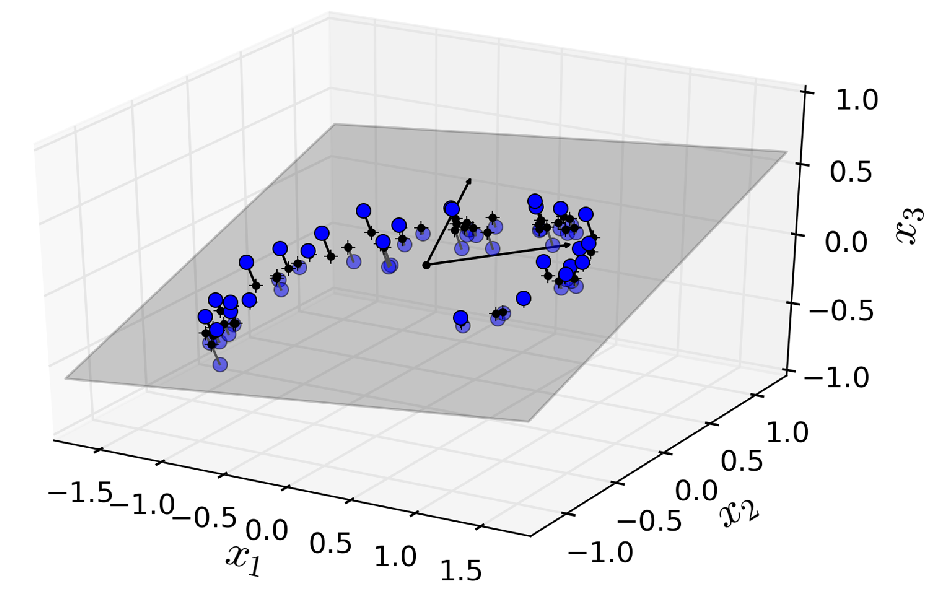

In [2]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict1.png'))
plt.grid(False)
plt.axis('off');

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D)
subspace of the high-dimensional (3D) space. Now if we project every training
instance perpendicularly onto this subspace (as represented by the short lines connecting
the instances to the plane), we get the new 2D dataset

However, projection is not always the best approach to dimensionality reduction. In
many cases the subspace may twist and turn, such as in the famous Swiss roll toy dataset
represented below

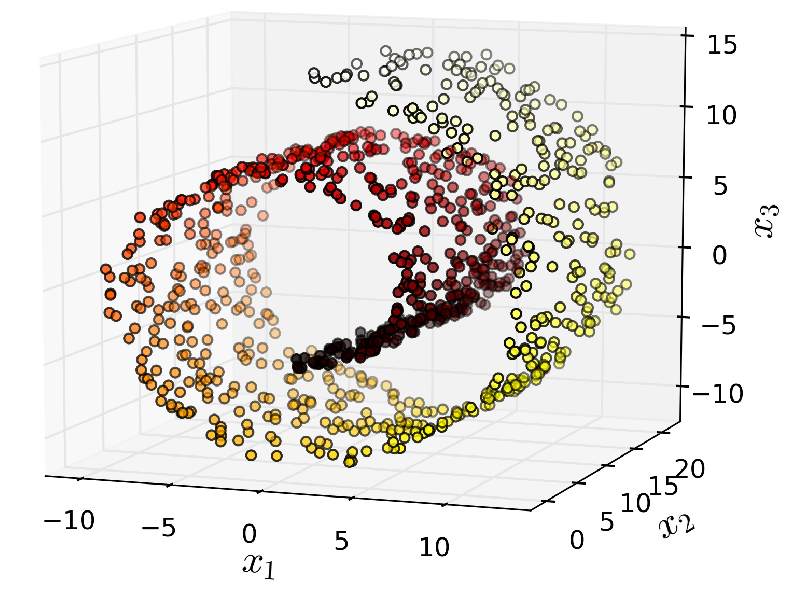

In [3]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict2.png'))
plt.grid(False)
plt.axis('off');

Simply projecting onto a plane (e.g., by dropping x3) would squash different layers of
the Swiss roll together, as shown on the left of Figure 8-5. However, what you really
want is to unroll the Swiss roll to obtain the 2D dataset on the right of Figure 8-5.

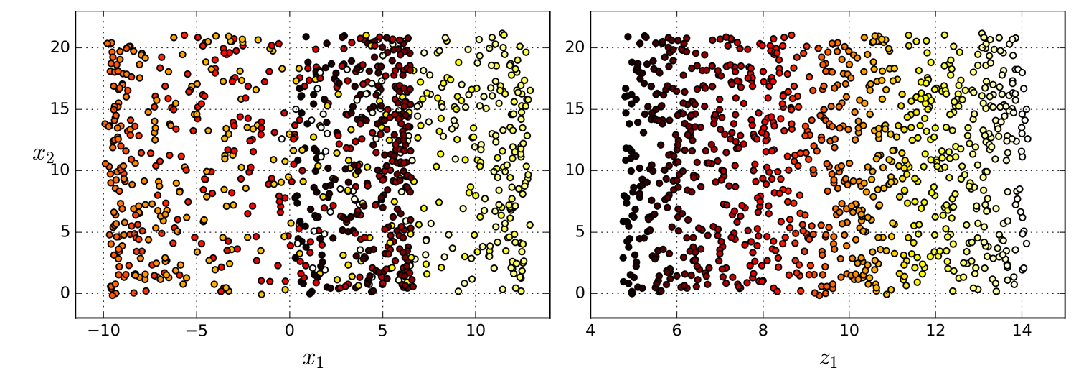

In [4]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict3.png'))
plt.grid(False)
plt.axis('off');

Squashing by projecting onto a plane (left) versus unrolling the Swiss roll
(right)

### Manifold Learning

The Swiss roll is an example of a 2D manifold. Put simply, a 2D manifold is a 2D
shape that can be bent and twisted in a higher-dimensional space. More generally, a
d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally
resembles a d-dimensional hyperplane. In the case of the Swiss roll, d = 2 and n = 3: it
locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which
the training instances lie; this is called Manifold Learning. It relies on the manifold
assumption, also called the manifold hypothesis, which holds that most real-world
high-dimensional datasets lie close to a much lower-dimensional manifold. This
assumption is very often empirically observed.

Once again, think about the MNIST dataset: all handwritten digit images have some
similarities. They are made of connected lines, the borders are white, they are more
or less centered, and so on. If you randomly generated images, only a ridiculously
tiny fraction of them would look like handwritten digits. In other words, the degrees
of freedom available to you if you try to create a digit image are dramatically lower
than the degrees of freedom you would have if you were allowed to generate any
image you wanted. These constraints tend to squeeze the dataset into a lowerdimensional
manifold.

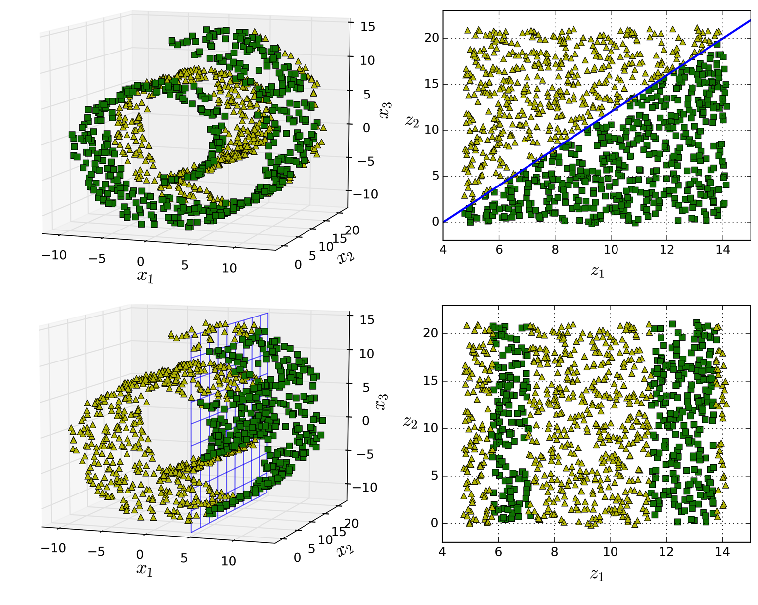

In [5]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict4.png'))
plt.grid(False)
plt.axis('off');

The manifold assumption is often accompanied by another implicit assumption: that
the task at hand (e.g., classification or regression) will be simpler if expressed in the
lower-dimensional space of the manifold. For example, in the top row of Figure the Swiss roll is split into two classes: in the 3D space (on the left), the decision
boundary would be fairly complex, but in the 2D unrolled manifold space (on the
right), the decision boundary is a simple straight line.


However, this assumption does not always hold. For example, in the bottom row of Figure, the decision boundary is located at x1 = 5. This decision boundary looks
very simple in the original 3D space (a vertical plane), but it looks more complex in
the unrolled manifold (a collection of four independent line segments).

In short, if you reduce the dimensionality of your training set before training a
model, it will definitely speed up training, but it may not always lead to a better or
simpler solution; it all depends on the dataset.


Hopefully you now have a good sense of what the curse of dimensionality is and how
dimensionality reduction algorithms can fight it, especially when the manifold
assumption holds. The rest of this chapter will go through some of the most popular
algorithms.

---

## Principal Component Analysis (PCA)

### Preserving the Variance

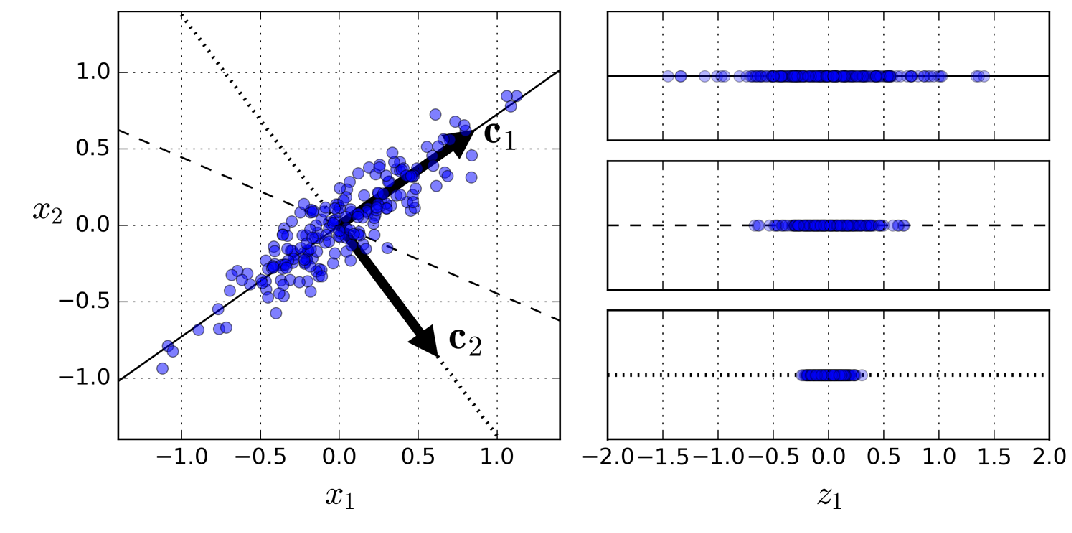

In [6]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict5.png'))
plt.grid(False)
plt.axis('off');

Before you can project the training set onto a lower-dimensional hyperplane, you
first need to choose the right hyperplane. For example, a simple 2D dataset is represented
on the left of Figure, along with three different axes (i.e., one-dimensional
hyperplanes). On the right is the result of the projection of the dataset onto each of
these axes. As you can see, the projection onto the solid line preserves the maximum
variance, while the projection onto the dotted line preserves very little variance, and
the projection onto the dashed line preserves an intermediate amount of variance.

It seems reasonable to select the axis that preserves the maximum amount of variance,
as it will most likely lose less information than the other projections. Another
way to justify this choice is that it is the axis that minimizes the mean squared distance
between the original dataset and its projection onto that axis. This is the rather
simple idea behind PCA.

### Principal Components

PCA identifies the axis that accounts for the largest amount of variance in the training
set. In Figure 8-7, it is the solid line. It also finds a second axis, orthogonal to the
first one, that accounts for the largest amount of remaining variance. In this 2D
example there is no choice: it is the dotted line. If it were a higher-dimensional dataset,
PCA would also find a third axis, orthogonal to both previous axes, and a fourth,
a fifth, and so on—as many axes as the number of dimensions in the dataset.

So how can you find the principal components of a training set? Luckily, there is a
standard matrix factorization technique called Singular Value Decomposition (SVD)
that can decompose the training set matrix X into the dot product of three matrices U
· Σ · V^T, where V^T contains all the principal components that we are looking for

In [7]:
# X_centered = X - X.mean(axis=0)
# U, s, V = np.linalg.svd(X_centered)
# c1 = V.T[:, 0]
# c2 = V.T[:, 1]

### Projecting Down to d Dimensions

Once you have identified all the principal components, you can reduce the dimensionality
of the dataset down to d dimensions by projecting it onto the hyperplane
defined by the first d principal components. Selecting this hyperplane ensures that the
projection will preserve as much variance as possible. For example, in Figure 8-2 the
3D dataset is projected down to the 2D plane defined by the first two principal components,
preserving a large part of the dataset’s variance. As a result, the 2D projection
looks very much like the original 3D dataset.

To project the training set onto the hyperplane, you can simply compute the dot
product of the training set matrix X by the matrix Wd, defined as the matrix contain‐ing the first d principal components (i.e., the matrix composed of the first d columns
of VT)

Projecting the training set down to d dimensions

$X_{d-proj} = X . W_d$

The python code implementation:

In [9]:
# W2 = V.T[:, :2] # the first to principal components
# X2d = X_centered.dot(W2) 

### Using scikit-learn

In [12]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# X2d = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, you can access the principal components
using the components_ variable (note that it contains the PCs as horizontal vectors,
so, for example, the first principal component is equal to pca.components_.T[:,
0]).

### Explained Variance Ratio

Another very useful piece of information is the explained variance ratio of each principal
component, available via the explained_variance_ratio_ variable. It indicates
the proportion of the dataset’s variance that lies along the axis of each principal component.

print(pca.explained_variance_ratio_) <br>
array([ 0.84248607, 0.14631839])

This tells you that 84.2% of the dataset’s variance lies along the first axis, and 14.6%
lies along the second axis. This leaves less than 1.2% for the third axis, so it is reasonable
to assume that it probably carries little information.

### Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is
generally preferable to choose the number of dimensions that add up to a sufficiently
large portion of the variance (e.g., 95%). Unless, of course, you are reducing dimensionality
for data visualization—in that case you will generally want to reduce the
dimensionality down to 2 or 3.

The following code computes PCA without reducing dimensionality, then computes
the minimum number of dimensions required to preserve 95% of the training set’s
variance:

In [13]:
# pca = PCA()
# pca.fit(X)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1

You could then set n_components=d and run PCA again. However, there is a much
better option: instead of specifying the number of principal components you want to
preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the
ratio of variance you wish to preserve:

In [15]:
# pca = PCA(n_components=0.95)
# X_reduced = pca.fit_transform(X)

Yet another option is to plot the explained variance as a function of the number of
dimensions (simply plot cumsum). There will usually be an elbow in the
curve, where the explained variance stops growing fast. You can think of this as the
intrinsic dimensionality of the dataset. In this case, you can see that reducing the
dimensionality down to about 100 dimensions wouldn’t lose too much explained variance.

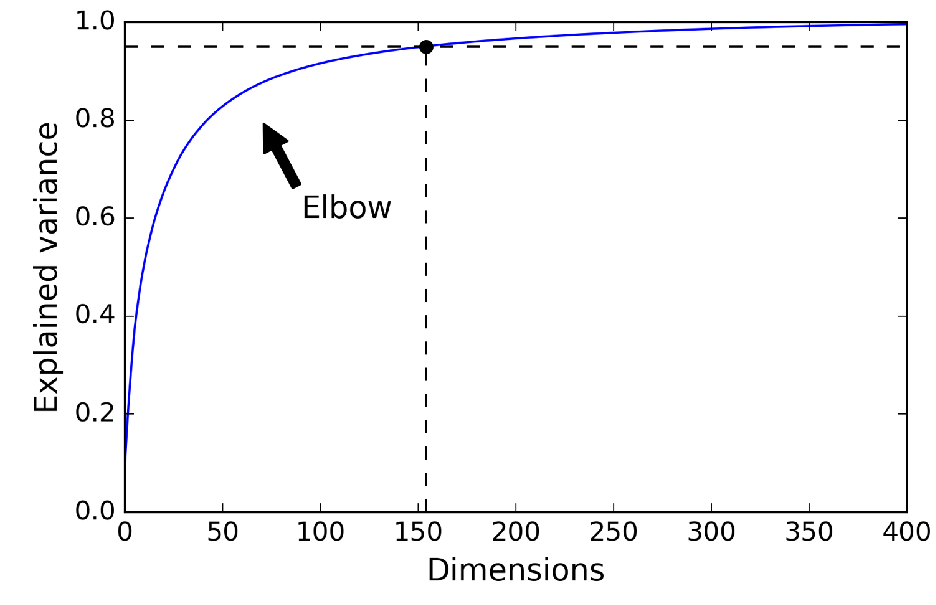

In [16]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict6.png'))
plt.grid(False)
plt.axis('off');

### PCA for Compression

Obviously after dimensionality reduction, the training set takes up much less space.
For example, try applying PCA to the MNIST dataset while preserving 95% of its variance.
You should find that each instance will have just over 150 features, instead of
the original 784 features. So while most of the variance is preserved, the dataset is
now less than 20% of its original size! This is a reasonable compression ratio, and you
can see how this can speed up a classification algorithm (such as an SVM classifier)
tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by
applying the inverse transformation of the PCA projection. Of course this won’t give
you back the original data, since the projection lost a bit of information (within the
5% variance that was dropped), but it will likely be quite close to the original data.
The mean squared distance between the original data and the reconstructed data
(compressed and then decompressed) is called the reconstruction error. For example,
the following code compresses the MNIST dataset down to 154 dimensions, then uses
the inverse_transform() method to decompress it back to 784 dimensions.

The equation of the inverse transformation:

$X_{recovered} = X_{d-proj} . W_d^T$

### Incremental PCA

One problem with the preceding implementation of PCA is that it requires the whole
training set to fit in memory in order for the SVD algorithm to run. Fortunately,
Incremental PCA (IPCA) algorithms have been developed: you can split the training
set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is
useful for large training sets, and also to apply PCA online (i.e., on the fly, as new
instances arrive).

The following code splits the MNIST dataset into 100 mini-batches (using NumPy’s
array_split() function) and feeds them to Scikit-Learn’s IncrementalPCA class to
reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like
before). Note that you must call the partial_fit() method with each mini-batch
rather than the fit() method with the whole training set:

In [17]:
# from sklearn.decomposition import IncrementalPCA

# n_batches = 100
# inc_pca = IncrementalPCA(n_components=154)
# for X_batch in np.array_split(X_mnist, n_batches):
#     inc_pca.partial_fit(X_batch)
    
# X_mnist_reduced = inc_pca.transform(X_mnist)

### Randomized PCA

Scikit-Learn offers yet another option to perform PCA, called Randomized PCA. This
is a stochastic algorithm that quickly finds an approximation of the first d principal
components. Its computational complexity is O(m × d2) + O(d3), instead of O(m × n2) + O(n3), so it is dramatically faster than the previous algorithms when d is much
smaller than n.

In [18]:
# rnd_pca = PCA(n_components=154, svd_solver='randomized')
# X_reduced = rnd_pca.fit_transform(X_mnist)

---

## Kernel PCA

Recall that a
linear decision boundary in the high-dimensional feature space corresponds to a
complex nonlinear decision boundary in the original space. It turns out that the same trick can be applied to PCA, making it possible to perform
complex nonlinear projections for dimensionality reduction. This is called Kernel
PCA (kPCA). It is often good at preserving clusters of instances after projection, or
sometimes even unrolling datasets that lie close to a twisted manifold.

In [19]:
# from sklearn.decomposition import KernelPCA

# rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
# X_reduced = rbf_pca.fit_transform(X)

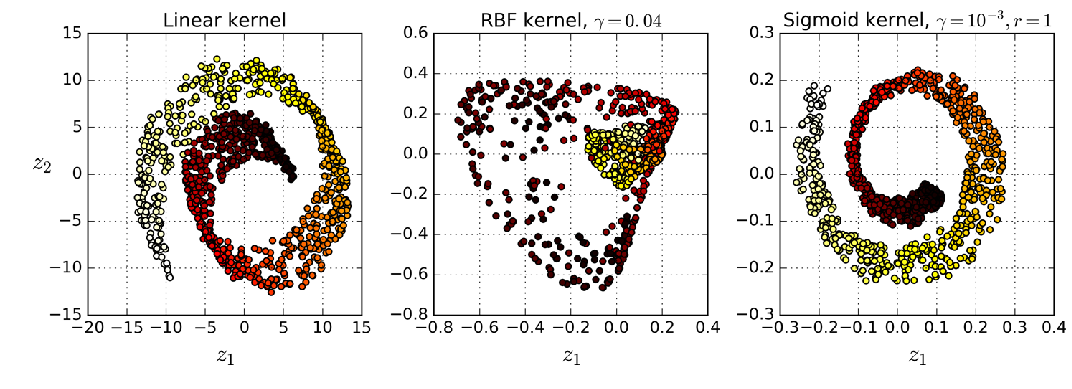

In [20]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict7.png'))
plt.grid(False)
plt.axis('off');

Figure shows the Swiss roll, reduced to two dimensions using a linear kernel
(equivalent to simply using the PCA class), an RBF kernel, and a sigmoid kernel
(Logistic).

### Selecting a Kernel and Tuning Hyperparameters

As kPCA is an unsupervised learning algorithm, there is no obvious performance
measure to help you select the best kernel and hyperparameter values. However,
dimensionality reduction is often a preparation step for a supervised learning task
(e.g., classification), so you can simply use grid search to select the kernel and hyperparameters
that lead to the best performance on that task. For example, the following
code creates a two-step pipeline, first reducing dimensionality to two dimensions
using kPCA, then applying Logistic Regression for classification. Then it uses Grid
SearchCV to find the best kernel and gamma value for kPCA in order to get the best
classification accuracy at the end of the pipeline:

In [21]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline

# clf = Pipeline([
#     ('kpca', KernelPCA(n_components)),
#     ('log_reg', LogisticRegression())
# ])

# param_grid = [{
#     'kpca__gamma' : np.linspace(0.03, 0.05, 10).
#     'kpca_kernel' : ['rbf', 'sigmoid']
# }]

# grid_search = GridSearchCV(clf, param_grid, cv=3).fit(X, y)

---